In [1]:
#database final.sqlite is created after cleaning the amazon food reviews data

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.metrics import classification_report 
from sklearn import cross_validation
import sqlite3
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable
    
x = PrettyTable()

con=sqlite3.connect("final.sqlite")

# time based sorting
clean_reviews=pd.read_sql_query(""" Select * from Reviews Order By Time""" , con)
clean_reviews=clean_reviews[:100000]
cleaned_text=clean_reviews['CleanedText'].values
score=clean_reviews['Score']
score.value_counts()


C:\Users\Anvesh Pandey\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


positive    87729
negative    12271
Name: Score, dtype: int64

This is an unbalanced dataset

In [2]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorization", "Model", "k", "f1 score", "Accuracy"]

#Featurization using Bag of Words and model using kNN for classification of review

In [3]:
#Featurization using BoW

from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer()#max_features=300)
final_counts=count_vect.fit_transform(cleaned_text)

svd = TruncatedSVD(n_components=3000, n_iter=7, random_state=42)
s=svd.fit_transform(final_counts)
#svd.explained_variance_ratio_
#svd.explained_variance_
#count_vect.get_feature_names()
#np.shape(s)
#final_counts=final_counts.toarray()


checking for first 3000 features: lets see how much variance does this cover

In [4]:
svd = TruncatedSVD(n_components=3000, n_iter=7, random_state=42)
s=svd.fit_transform(final_counts)
no_of_features=np.array([100,200,300,500,1000,1500,2000,3000])
variances=[]
for i in no_of_features:
    variances.append(np.sum(svd.explained_variance_ratio_[:i]))

Text(0.5,1,'no_of_features vs variances')

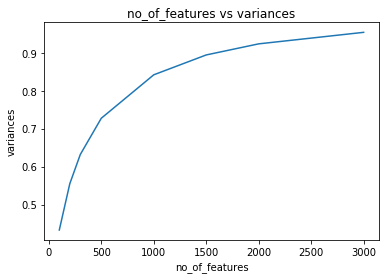

In [5]:
plt.plot(no_of_features,variances)
plt.xlabel("no_of_features")
plt.ylabel("variances")
plt.title("no_of_features vs variances")

The plot shows that 80% of variance is covered with 1000 features

In [6]:
#variance with 300 features
np.sum(svd.explained_variance_ratio_[:300])

0.6319196553731413

300 features give us decent amount of information: 63.2% information for 300 features

This is good amount of information : not much data is lost
Therefore taking 300 feAtures for this exercise

In [7]:
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
final_counts=svd.fit_transform(final_counts)

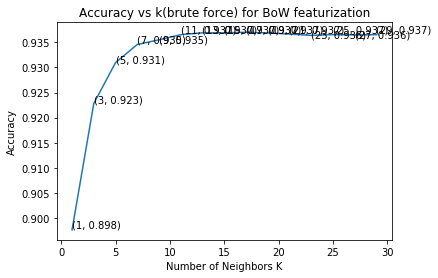

Optimal_k for BoW featurizatin and knn(brute force) is  17
Accuracy is  88.09


In [8]:
#kNN brute with 3 fold CV
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(final_counts,score,test_size=0.3,random_state=0)
k_values=np.arange(1,30,2)
cv_scores=[]
custom_scorer=make_scorer(f1_score,pos_label="positive")
for k in k_values:
    knn=KNeighborsClassifier(n_neighbors=k,weights="distance",algorithm="brute")
    scores=cross_val_score(knn,x_tr,y_tr,cv=3,scoring=custom_scorer)
    cv_scores.append(scores.mean())

optimal_k=k_values[cv_scores.index(max(cv_scores))]
plt.plot(k_values,cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_score')
plt.title("f1_score vs k(brute force) for BoW featurization")
for xy in zip(k_values, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.show()
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k,weights="distance",algorithm="brute")
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc=accuracy_score(y_test,pred)

print ("Optimal_k for BoW featurizatin and knn(brute force) is ",optimal_k)
np.round(acc*100,2)
print ("Accuracy is ",np.round(acc*100,2))


Performance becomes somewhat stable at k=17

In [9]:
y_test=np.asarray(y_test)

f score is  0.8397563611393886
[[  362  3395]
 [  178 26065]]
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

   negative       0.67      0.10      0.17      3757
   positive       0.88      0.99      0.94     26243

avg / total       0.86      0.88      0.84     30000



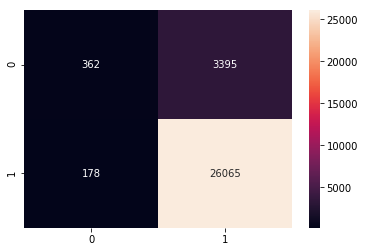

In [10]:

f1=f1_score(y_test,pred,average='weighted')
print ("f score is ", f1)
c_matrix=confusion_matrix(y_test, pred)
print (c_matrix)
print (sns.heatmap(c_matrix,annot=True,fmt="d"))
print (classification_report(y_test, pred))

f1 score is also decent for k=17: It shows 84% f1-score which is good

In [11]:
x.add_row(["BoW","kNN Brute force",optimal_k,f1,acc])

Reducing the number of reviews to 30k for kd tree

In [12]:
#kNN kd tree 
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(final_counts[:30000],score[:30000],test_size=0.3,random_state=0)
k_values=np.arange(1,30,2) 
cv_scores=[] 
custom_scorer=make_scorer(f1_score,pos_label="positive")

for k in k_values:   
    knn=KNeighborsClassifier(n_neighbors=k,weights="distance",algorithm="kd_tree")    
    scores=cross_val_score(knn,x_tr,y_tr,cv=3,scoring=custom_scorer)    
    cv_scores.append(scores.mean()) 
optimal_k=k_values[cv_scores.index(max(cv_scores))] 

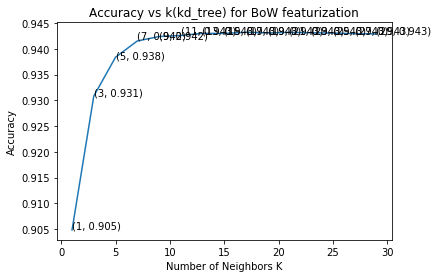

Optimal_k for BoW featurizatin and knn(kd tree) is  17
Accuracy is  89.61


In [13]:
plt.plot(k_values,cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_score')
plt.title("f1_score vs k(kd_tree) for BoW featurization")
for xy in zip(k_values, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.show()
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k,weights="distance",algorithm="brute")
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc=accuracy_score(y_test,pred)
print ("Optimal_k for BoW featurizatin and knn(kd tree) is ",optimal_k)
np.round(acc*100,2)
print ("Accuracy is ",np.round(acc*100,2))

The y label in the graph says accuracy but it is actually plotted against f1-score

good performance is evident with k=17

f score is  0.853711627064626
[[  41  909]
 [  26 8024]]
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

   negative       0.61      0.04      0.08       950
   positive       0.90      1.00      0.94      8050

avg / total       0.87      0.90      0.85      9000



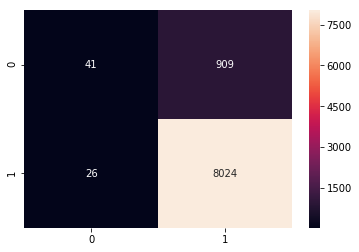

In [14]:
f1=f1_score(y_test,pred,average='weighted')
print ("f score is ", f1)
c_matrix=confusion_matrix(y_test, pred)
print (c_matrix)
print (sns.heatmap(c_matrix,annot=True,fmt="d"))
print (classification_report(y_test, pred))

f1 score of 85.37% gives a lot of confidence on the model

In [15]:
x.add_row(["BoW","kNN kd_tree",optimal_k,f1,acc])

In [16]:
#Featurization using Tfidf and model using kNN for classification of review

In [17]:
#Tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
final_counts= tf_idf_vect.fit_transform(clean_reviews['CleanedText'].values)
final_counts=final_counts.toarray()

0.3891801669102287

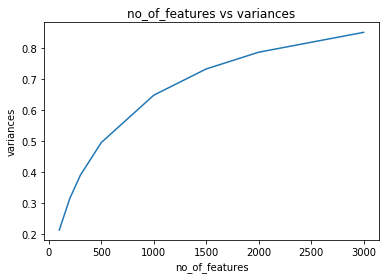

In [18]:
svd = TruncatedSVD(n_components=3000, n_iter=7, random_state=42)
s=svd.fit_transform(final_counts)
no_of_features=np.array([100,200,300,500,1000,1500,2000,3000])
variances=[]
for i in no_of_features:
    variances.append(np.sum(svd.explained_variance_ratio_[:i])) 

plt.plot(no_of_features,variances)
plt.xlabel("no_of_features")
plt.ylabel("variances")
plt.title("no_of_features vs variances")

#variance with 300 features
np.sum(svd.explained_variance_ratio_[:300])

TFIDF covers around 80% of the information with 3000 features. With 300 features around 39% of the information is retained.

In [19]:
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
final_counts=svd.fit_transform(final_counts)

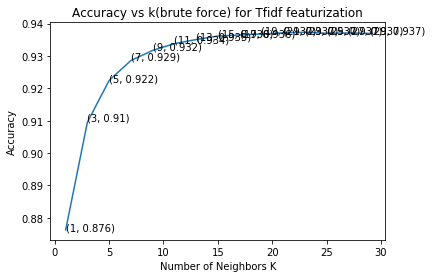

Optimal_k for Tfidf featurizatin and knn(brute force) is  23
Accuracy is  88.1


In [20]:
#kNN brute
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(final_counts,score,test_size=0.3,random_state=0)
k_values=np.arange(1,30,2)
cv_scores=[]
custom_scorer=make_scorer(f1_score,pos_label="positive")

for k in k_values:
    knn=KNeighborsClassifier(n_neighbors=k,weights="distance",algorithm="brute")
    scores=cross_val_score(knn,x_tr,y_tr,cv=3,scoring=custom_scorer)
    cv_scores.append(scores.mean())

optimal_k=k_values[cv_scores.index(max(cv_scores))]
plt.plot(k_values,cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_score')
plt.title("f1_score vs k(brute force) for Tfidf featurization")
for xy in zip(k_values, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.show()
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k,weights="distance",algorithm="brute")
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc=accuracy_score(y_test,pred)
print ("Optimal_k for Tfidf featurizatin and knn(brute force) is ",optimal_k)
np.round(acc*100,2)
print ("Accuracy is ",np.round(acc*100,2))





The y label in the graph says accuracy but it is actually plotted against f1-score

k=23 gives decent performance (84.32%) with tfidf and knn(brute force)

f score is  0.8432497494428263
[[  438  3319]
 [  250 25993]]
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

   negative       0.64      0.12      0.20      3757
   positive       0.89      0.99      0.94     26243

avg / total       0.86      0.88      0.84     30000



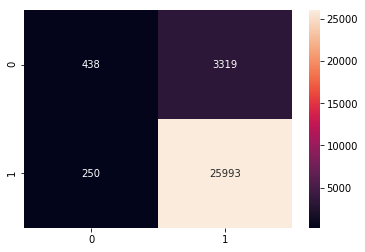

In [21]:
f1=f1_score(y_test,pred,average='weighted')
print ("f1 score is ", f1)
c_matrix=confusion_matrix(y_test, pred)
print (c_matrix)
print (sns.heatmap(c_matrix,annot=True,fmt="d"))
print (classification_report(y_test, pred))

f1 score of 85% infuses confidence in the model

In [22]:
x.add_row(["tfIdf","kNN Brute force",optimal_k,f1,acc])


In [23]:
#kNN kd tree
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(final_counts[:30000],score[:30000],test_size=0.3,random_state=0)
k_values=np.arange(1,30,2)
cv_scores=[]
custom_scorer=make_scorer(f1_score,pos_label="positive")

for k in k_values:
    knn=KNeighborsClassifier(n_neighbors=k,weights="distance",algorithm="kd_tree")
    scores=cross_val_score(knn,x_tr,y_tr,cv=3,scoring=custom_scorer)
    cv_scores.append(scores.mean())

optimal_k=k_values[cv_scores.index(max(cv_scores))]



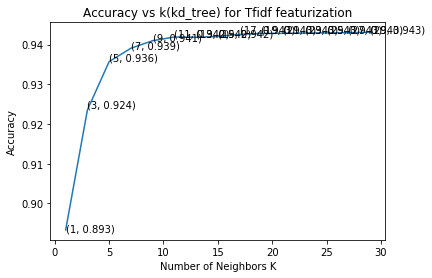

Optimal_k for Tfidf featurizatin and knn(kd tree) is  29
Accuracy is  89.61


In [24]:
plt.plot(k_values,cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_score')
plt.title("f1_score vs k(kd_tree) for Tfidf featurization")
for xy in zip(k_values, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.show()
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k,weights="distance",algorithm="brute")
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc=accuracy_score(y_test,pred)
print ("Optimal_k for Tfidf featurizatin and knn(kd tree) is ",optimal_k)
np.round(acc*100,2)
print ("Accuracy is ",np.round(acc*100,2))

The y label in the graph says accuracy but it is actually plotted against f1-score

f1_score at around 85% for k=29 is goood enough

f score is  0.8510452084867651
[[  27  923]
 [  12 8038]]
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

   negative       0.69      0.03      0.05       950
   positive       0.90      1.00      0.95      8050

avg / total       0.88      0.90      0.85      9000



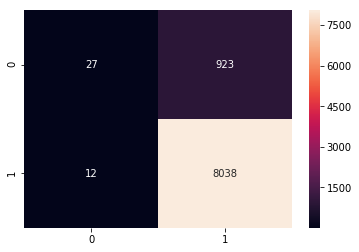

In [25]:
f1=f1_score(y_test,pred,average='weighted')
print ("f1 score is ", f1)
c_matrix=confusion_matrix(y_test, pred)
print (c_matrix)
print (sns.heatmap(c_matrix,annot=True,fmt="d"))
print (classification_report(y_test, pred))

86.2% f1 score is good enough for the model

In [26]:
x.add_row(["tfIdf","kNN kd_tree",optimal_k,f1,acc])

#Featurization using avgWord2Vec and model using kNN for classification of review

In [27]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in clean_reviews['CleanedText'].values:
    list_of_sent.append(sent.split())


In [28]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

final_counts=sent_vectors

C:\Users\Anvesh Pandey\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


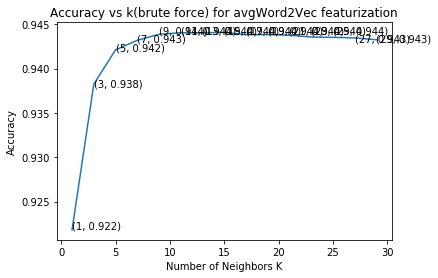

Optimal_k for avgWord2Vec featurization and knn(brute force) is  15
Accuracy is  89.47


In [29]:
#kNN brute
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(final_counts,score,test_size=0.3,random_state=0)
k_values=np.arange(1,30,2)
cv_scores=[]
custom_scorer=make_scorer(f1_score,pos_label="positive")

for k in k_values:
    knn=KNeighborsClassifier(n_neighbors=k,weights="distance",algorithm="brute")
    scores=cross_val_score(knn,x_tr,y_tr,cv=3,scoring=custom_scorer)
    cv_scores.append(scores.mean())

optimal_k=k_values[cv_scores.index(max(cv_scores))]
plt.plot(k_values,cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_score')
plt.title("f1_score vs k(brute force) for avgWord2Vec featurization")
for xy in zip(k_values, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.show()
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k,weights="distance",algorithm="brute")
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc=accuracy_score(y_test,pred)
print ("Optimal_k for avgWord2Vec featurization and knn(brute force) is ",optimal_k)
np.round(acc*100,2)
print ("Accuracy is ",np.round(acc*100,2))

In [ ]:
The y label in the graph says accuracy but it is actually plotted against f1-score

f score is  0.8702250481068007
[[  906  2851]
 [  307 25936]]
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

   negative       0.75      0.24      0.36      3757
   positive       0.90      0.99      0.94     26243

avg / total       0.88      0.89      0.87     30000



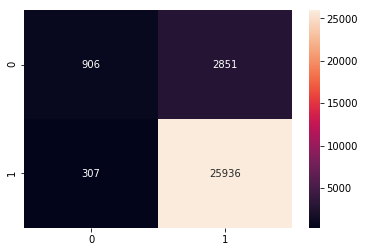

In [30]:
f1=f1_score(y_test,pred,average='weighted')
print ("f1 score is ", f1)
c_matrix=confusion_matrix(y_test, pred)
print (c_matrix)
print (sns.heatmap(c_matrix,annot=True,fmt="d"))
print (classification_report(y_test, pred))

good f1 score - 87.5% is achieved with avgWord2Vec

In [31]:
x.add_row(["avgWord2Vec","kNN Brute force",optimal_k,f1,acc])

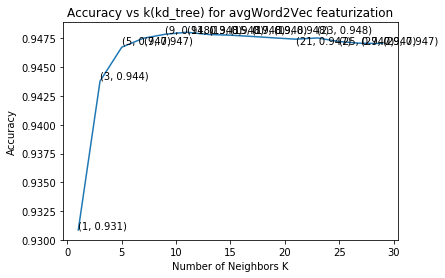

Optimal_k for avgWord2Vec featurizatin and knn(kd tree) is  11
Accuracy is  90.87


In [32]:
#kNN kd tree
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(final_counts[:30000],score[:30000],test_size=0.3,random_state=0)
k_values=np.arange(1,30,2)
cv_scores=[]
custom_scorer=make_scorer(f1_score,pos_label="positive")

for k in k_values:
    knn=KNeighborsClassifier(n_neighbors=k,weights="distance",algorithm="kd_tree")
    scores=cross_val_score(knn,x_tr,y_tr,cv=3,scoring=custom_scorer)
    cv_scores.append(scores.mean())

optimal_k=k_values[cv_scores.index(max(cv_scores))]
plt.plot(k_values,cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_score')
plt.title("f1_score vs k(kd_tree) for avgWord2Vec featurization")
for xy in zip(k_values, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.show()
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k,weights="distance",algorithm="brute")
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc=accuracy_score(y_test,pred)
print ("Optimal_k for avgWord2Vec featurizatin and knn(kd tree) is ",optimal_k)
np.round(acc*100,2)
print ("Accuracy is ",np.round(acc*100,2))


The y label in the graph says accuracy but it is actually plotted against f1-score

f score is  0.8847278919509622
[[ 196  754]
 [  68 7982]]
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

   negative       0.74      0.21      0.32       950
   positive       0.91      0.99      0.95      8050

avg / total       0.90      0.91      0.88      9000



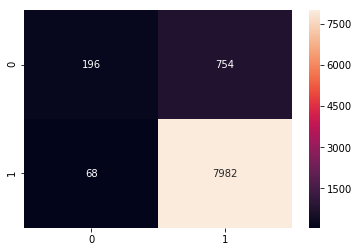

In [33]:
f1=f1_score(y_test,pred,average='weighted')
print ("f score is ", f1)
c_matrix=confusion_matrix(y_test, pred)
print (c_matrix)
print (sns.heatmap(c_matrix,annot=True,fmt="d"))
print (classification_report(y_test, pred))

With kdtree we have imporved f1 score (88.3%) , that is reasonable

In [34]:
x.add_row(["avgWord2Vec","kNN kd_tree",optimal_k,f1,acc])

#Featurization using avgWord2Vec-tfidf and model using kNN for classification of review

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() 
final_tf_idf = tf_idf_vect.fit_transform(clean_reviews['CleanedText'].values)
tfidf_sent_vectors = []; 
row=0;
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf =final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

final_counts=tfidf_sent_vectors

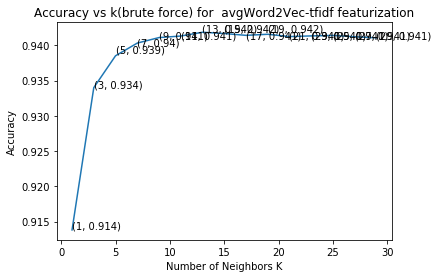

Optimal_k for  avgWord2Vec-tfidf featurizatin and knn(brute force) is  13
Accuracy is  88.96


In [36]:
#kNN brute
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(final_counts,score,test_size=0.3,random_state=0)
k_values=np.arange(1,30,2)
cv_scores=[]
custom_scorer=make_scorer(f1_score,pos_label="positive")

for k in k_values:
    knn=KNeighborsClassifier(n_neighbors=k,weights="distance",algorithm="brute")
    scores=cross_val_score(knn,x_tr,y_tr,cv=3,scoring=custom_scorer)
    cv_scores.append(scores.mean())

optimal_k=k_values[cv_scores.index(max(cv_scores))]
plt.plot(k_values,cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_score')
plt.title("f1_score vs k(brute force) for  avgWord2Vec-tfidf featurization")
for xy in zip(k_values, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.show()
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k,weights="distance",algorithm="brute")
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc=accuracy_score(y_test,pred)
print ("Optimal_k for  avgWord2Vec-tfidf featurizatin and knn(brute force) is ",optimal_k)
np.round(acc*100,2)
print ("Accuracy is ",np.round(acc*100,2))

The y label in the graph says accuracy but it is actually plotted against f1-score

f score is  0.8610781153386613
[[  744  3013]
 [  300 25943]]
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

   negative       0.71      0.20      0.31      3757
   positive       0.90      0.99      0.94     26243

avg / total       0.87      0.89      0.86     30000



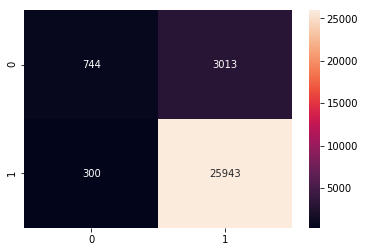

In [37]:
f1=f1_score(y_test,pred,average='weighted')
print ("f score is ", f1)
c_matrix=confusion_matrix(y_test, pred)
print (c_matrix)
print (sns.heatmap(c_matrix,annot=True,fmt="d"))
print (classification_report(y_test, pred))

In [38]:
x.add_row(["tfidf-avgWord2Vec","kNN Brute force",optimal_k,f1,acc])

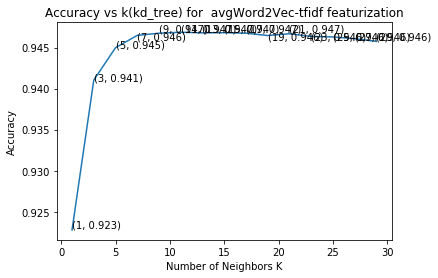

Optimal_k for  avgWord2Vec-tfidf featurizatin and knn(kd tree) is  11
Accuracy is  90.52


In [39]:
#kNN kd tree
x_tr,x_test,y_tr,y_test = cross_validation.train_test_split(final_counts[:30000],score[:30000],test_size=0.3,random_state=0)
k_values=np.arange(1,30,2)
cv_scores=[]
custom_scorer=make_scorer(f1_score,pos_label="positive")

for k in k_values:
    knn=KNeighborsClassifier(n_neighbors=k,weights="distance",algorithm="kd_tree")
    scores=cross_val_score(knn,x_tr,y_tr,cv=3,scoring=custom_scorer)
    cv_scores.append(scores.mean())

optimal_k=k_values[cv_scores.index(max(cv_scores))]
plt.plot(k_values,cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('f1_score')
plt.title("f1_score vs k(kd_tree) for  avgWord2Vec-tfidf featurization")
for xy in zip(k_values, np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.show()
knn_optimal=KNeighborsClassifier(n_neighbors=optimal_k,weights="distance",algorithm="brute")
knn_optimal.fit(x_tr,y_tr)
pred=knn_optimal.predict(x_test)
acc=accuracy_score(y_test,pred)
print ("Optimal_k for  avgWord2Vec-tfidf featurizatin and knn(kd tree) is ",optimal_k)
np.round(acc*100,2)
print ("Accuracy is ",np.round(acc*100,2))


In [ ]:
The y label in the graph says accuracy but it is actually plotted against f1-score

f score is  0.8805553500603039
[[ 182  768]
 [  85 7965]]
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

   negative       0.68      0.19      0.30       950
   positive       0.91      0.99      0.95      8050

avg / total       0.89      0.91      0.88      9000



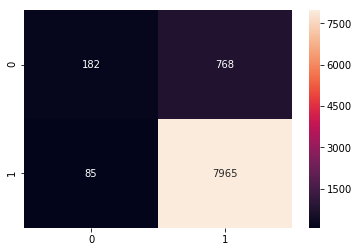

In [40]:
f1=f1_score(y_test,pred,average='weighted')
print ("f1 score is ", f1)
c_matrix=confusion_matrix(y_test, pred)
print (c_matrix)
print (sns.heatmap(c_matrix,annot=True,fmt="d"))
print (classification_report(y_test, pred))

In [41]:
x.add_row(["tfidf-avgWord2Vec","kNN kd_tree",optimal_k,f1,acc])

In [42]:
print (x)

+-------------------+-----------------+----+--------------------+--------------------+
|   Vectorization   |      Model      | k  |      f1 score      |      Accuracy      |
+-------------------+-----------------+----+--------------------+--------------------+
|        BoW        | kNN Brute force | 17 | 0.8397563611393886 |       0.8809       |
|        BoW        |   kNN kd_tree   | 17 | 0.853711627064626  | 0.8961111111111111 |
|       tfIdf       | kNN Brute force | 23 | 0.8432497494428263 | 0.8810333333333333 |
|       tfIdf       |   kNN kd_tree   | 29 | 0.8510452084867651 | 0.8961111111111111 |
|    avgWord2Vec    | kNN Brute force | 15 | 0.8702250481068007 | 0.8947333333333334 |
|    avgWord2Vec    |   kNN kd_tree   | 11 | 0.8847278919509622 | 0.9086666666666666 |
| tfidf-avgWord2Vec | kNN Brute force | 13 | 0.8610781153386613 | 0.8895666666666666 |
| tfidf-avgWord2Vec |   kNN kd_tree   | 11 | 0.8805553500603039 | 0.9052222222222223 |
+-------------------+-----------------+----

Conclusion - From the table it is evident that max f1 score of 88.47% is achieved using avgWord2Vec and KNN with kd_tree algo. Accuracy is also highest for the same model.Eleven nearest neighbors gives us the best model. We checked k in range till 30. 29 being the maximum value. 
  Therefore we will go with avgWord2Vec and KNN with kd_tree algo to design our model.